# preparer l'environnement

### import des biblio

In [1]:
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### definir les variables global

In [2]:
DATA_PATH = "./cifar-10-batches-py/"
modelName = "rnnNet"

### la fonction pour chager des fichiers

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### la fonction pour visualisation des data

In [4]:
def show_first_samples(x_train, y_train, labels_name):
    
    for i in range(4):
        imgs = x_train[i]
        img0 = imgs[0]
        img1 = imgs[1]
        img2 = imgs[2]
        i0 = Image.fromarray(img0)
        i1 = Image.fromarray(img1)
        i2 = Image.fromarray(img2)
        img = Image.merge("RGB",(i0,i1,i2))
        plt.imshow(img)
        print(labels_name[y_train[i]])
        plt.show()


### la fonction pour chager des data

In [5]:
def load_data():
    data_first = unpickle(DATA_PATH + "data_batch_1")
    data_x = data_first[b'data']
    data_y = data_first[b'labels']
    for i in range(2,6):
        data = unpickle(DATA_PATH + f"data_batch_{i}")
        data_x = np.vstack((data_x, data[b'data']))
        data_y += data[b'labels']
    return data_x, data_y


# Creation de model

#### Long short-term memory (LSTM) est une architecture de réseau neuronal récurrent artificiel (RNN)
#### input shape est (nb_sample, nb_time_step, input_dim)
#### ouput shape est (nb_sample, units)

In [6]:
def create_model():
    model = Sequential()

    
    model.add(LSTM(512, input_shape=x_train.shape[1:]))
    model.add(Dropout(0.25))

    model.add(Reshape((2, 256)))

    model.add(LSTM(100))
    model.add(Dropout(0.25))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return model

# Preparation des data

### chargement des data et visualisation des data

b'frog'


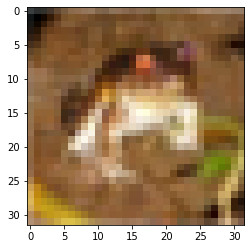

b'truck'


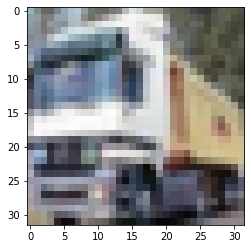

b'truck'


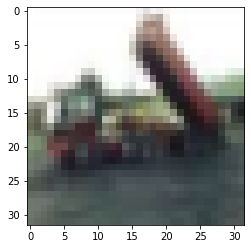

b'deer'


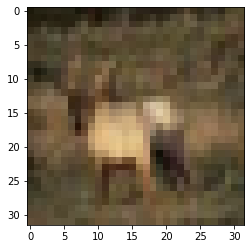

In [7]:
 x_train, y_train = load_data() #load the train data cifar

data_test = unpickle(DATA_PATH + "test_batch") # load the test data
x_val, y_val = data_test[b'data'], data_test[b'labels'] 

data_info = unpickle(DATA_PATH + "batches.meta") #load the data infos
labels_name = data_info[b'label_names']

x_image = x_train.reshape(-1, 3, 32, 32)

show_first_samples(x_image, y_train, labels_name)

### Formuler les data

In [8]:
x_train = x_train / 255.0
x_val = x_val / 255.0

x_train = x_train.reshape(-1, 3, 1024)
x_val = x_val.reshape(-1, 3, 1024)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Visualisation du model

### la resume du model

In [9]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               3147776   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
activation (Activation)      (None, 10)                0

### tracer l'image de structure

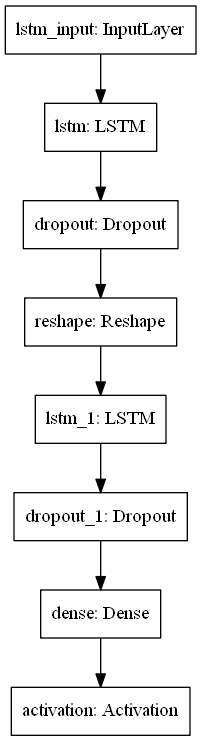

In [10]:
plot_model(model, f"{modelName}_log/{modelName}.png")

# Compile le model

### callbacks fonction : 
#### EarlyStopping : si val_accuracy n'ai pas augmenter deplus 2 epoch, la processus va arreter.
#### TensorBoard : une utils pour enregistrer les log

In [11]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                epochs=30,
                batch_size=128,
                callbacks=[
                    EarlyStopping(monitor="val_accuracy", patience=2),
                    TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                    ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 19s 378us/sample - loss: 1.9154 - accuracy: 0.3040 - val_loss: 1.7531 - val_accuracy: 0.3705
Epoch 2/30
50000/50000 [==============================] - 13s 262us/sample - loss: 1.7307 - accuracy: 0.3792 - val_loss: 1.6085 - val_accuracy: 0.4286
Epoch 3/30
50000/50000 [==============================] - 15s 307us/sample - loss: 1.6514 - accuracy: 0.4074 - val_loss: 1.5532 - val_accuracy: 0.4491
Epoch 4/30
50000/50000 [==============================] - 16s 316us/sample - loss: 1.5878 - accuracy: 0.4328 - val_loss: 1.5125 - val_accuracy: 0.4583
Epoch 5/30
50000/50000 [==============================] - 16s 315us/sample - loss: 1.5438 - accuracy: 0.4473 - val_loss: 1.4779 - val_accuracy: 0.4730
Epoch 6/30
50000/50000 [==============================] - 16s 313us/sample - loss: 1.5017 - accuracy: 0.4638 - val_loss: 1.4477 - val_accuracy: 0.4802
Epoch 7/30
50000/50000 [====================

# Visualisation des resultat

### visualisation de accuracy

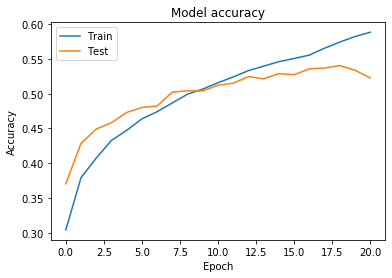

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_accuracy.png')
plt.show()

### visualisation de loss

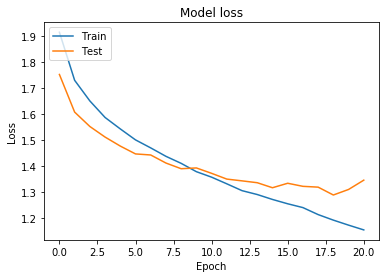

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_loss.png')
plt.show()